# Forecasting Video Game Sales
## Machine Learning Pipeline

### Loading the Data

In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Load dataset
FILEPATH = "../data/vgsales_consolidated.csv" # Relative to Git repo
df_raw = pd.read_csv(FILEPATH)

# Select relevant columns
df_raw = df_raw[['Name', 'Genre', 'Publisher', 'Year', 'Global_Sales', 'Decade', 'FranchiseTag']].dropna()
df_raw = df_raw.reset_index(drop=True)

# summary of df columns
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11338 entries, 0 to 11337
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          11338 non-null  object 
 1   Genre         11338 non-null  object 
 2   Publisher     11338 non-null  object 
 3   Year          11338 non-null  int64  
 4   Global_Sales  11338 non-null  float64
 5   Decade        11338 non-null  int64  
 6   FranchiseTag  11338 non-null  int64  
dtypes: float64(1), int64(3), object(3)
memory usage: 620.2+ KB
None


### Encoding Categorical Features

In [2]:
# Getting unique counts of categorical columns
print("Unique Genres:", df_raw['Genre'].nunique())
print("Unique Publishers:", df_raw['Publisher'].nunique())

Unique Genres: 12
Unique Publishers: 564


In [3]:
# One-hot encode categorical features
categorical_cols = ['Genre', 'Publisher']
df = pd.get_dummies(df_raw, columns=categorical_cols, drop_first=False)

# Scale numerical features
scaler = StandardScaler()
num_features = scaler.fit_transform(df[['Year']])

In [4]:
df.head()

,Name,Year,Global_Sales,Decade,FranchiseTag,Genre_action,Genre_adventure,Genre_fighting,Genre_misc,Genre_platform,...,Publisher_xseed games,Publisher_yacht club games,Publisher_yamasa entertainment,Publisher_yeti,Publisher_yukes,Publisher_yumedia,Publisher_zenrin,Publisher_zoo digital publishing,Publisher_zoo games,Publisher_zushi games
0,007 quantum of solace,2008,3.92,2000,0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,007 racing,2000,0.53,2000,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,007 the world is not enough,2000,2.47,2000,0,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,007 tomorrow never dies,1999,3.21,1990,0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1 vs 100,2008,0.09,2000,0,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


### Creating Title Embeddings Using BertTokenizer

In [44]:
from transformers import BertTokenizer, BertModel
import torch

# Load BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Tokenize titles
titles = df['Name'].tolist()
inputs = tokenizer(titles, padding=True, truncation=True, return_tensors="pt")

# Generate embeddings
with torch.no_grad():
    outputs = bert_model(**inputs)

# Use [CLS] token embedding
title_embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # shape: (num_samples, 768)


C:\Users\maxac\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [45]:
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq

# assume title_embeddings is a numpy array shape (N, D) dtype float32
X = title_embeddings.astype(np.float32)  # (N, D)
ids = [f"doc_{i}" for i in range(X.shape[0])]
meta = df['Name'].astype(str).tolist()    # or other metadata

# Build pandas DataFrame with embedding as Python list per row
df_parquet = pd.DataFrame({
    "id": ids,
    "title": meta,
    "embedding": X.tolist()   # list[float]
})

# Create explicit pyarrow schema using list<float32>
pa_schema = pa.schema([
    pa.field("id", pa.string()),
    pa.field("title", pa.string()),
    pa.field("embedding", pa.list_(pa.float32()))
])

table = pa.Table.from_pandas(df_parquet, schema=pa_schema, preserve_index=False)
pq.write_table(table, "title_embeddings.parquet", compression="zstd", row_group_size=100_000)

In [5]:
import pyarrow.dataset as ds
import numpy as np

dataset = ds.dataset("../data/title_embeddings.parquet", format="parquet")

for batch in dataset.to_batches(batch_size=50_000, columns=["id","title","embedding"]):
    pdf = batch.to_pandas()
    emb_batch = np.vstack(pdf["embedding"].values).astype(np.float32)  # (B, D)
    # use emb_batch for indexing or inference

In [6]:
# extracting column from pandas DataFrame
ids = pdf['id'].tolist()
titles = pdf['title']
embeddings = np.vstack(pdf['embedding'].values).astype(np.float32)  # (N, D)

In [7]:
embeddings.shape  # (N, D)

(11338, 768)

In [8]:
import numpy as np

# Combine all features
X = np.concatenate([
    titles.values.reshape(-1, 1),
    embeddings,
    df[['FranchiseTag']].values,
    df.iloc[:, 5:581].values,  # Columns 5-580, which are one-hot encoded categorical features
    num_features
], axis=1)

y = df['Global_Sales'].values
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Feature matrix shape: (11338, 1347)
Target vector shape: (11338,)


### Data Split

In [9]:
# Perform 80-20 train-test split
from sklearn.model_selection import train_test_split

X_train_name, X_test_name, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = X_train_name[:, 1:].astype(np.float32)  # Exclude title column for model training
X_test = X_test_name[:, 1:].astype(np.float32)    # Exclude title column for model testing

print("Training set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Training set shape: (9070, 1346) (9070,)
Test set shape: (2268, 1346) (2268,)


In [10]:
# Store X_train_name, X_test_name, y_train, y_test for later use
np.savez("../data/train_test_split.npz", X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test)
np.save("../data/X_train_name.npy", X_train_name)
np.save("../data/X_test_name.npy", X_test_name)

data = np.load("../data/train_test_split.npz")
X_train, X_test = data["X_train"], data["X_test"]


### K-Nearest Neighbors

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

# Hyperparameter tuning for KNN

param_grid = {
    'n_neighbors': range(1, 31),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski'],
    'p': [1, 2]
}

grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)


Best parameters: {'metric': 'euclidean', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}
Best score: 0.23877160965183145


In [13]:
# Storing KNN model
import joblib
joblib.dump(grid.best_estimator_, '../models/knn_model.joblib')

['../models/knn_model.joblib']

In [14]:
knn_params = {'metric': 'euclidean', 'n_neighbors': 12, 'p': 1, 'weights': 'distance'}

In [32]:
# Evaluate on test set
best_knn = joblib.load('../models/knn_model.joblib')
knn_pred = best_knn.predict(X_test)

# Constructing dataframe of names, global sales, and predictions
knn_results_df = pd.DataFrame({
    "Name": X_test_name[:, 0],  # Names from the name-included test set
    "Actual_Global_Sales": y_test,
    "Predicted_Global_Sales": knn_pred.flatten()
})

# viewing model predictions
knn_results_df

,Name,Actual_Global_Sales,Predicted_Global_Sales
0,chronicles of mystery the secret tree of life,0.08,0.252238
1,back at the barnyard slop bucket games,0.14,0.362859
2,earth defense force 2025,0.51,0.263754
3,scoobydoo unmasked,0.75,0.523497
4,mlb 10 the show,1.32,1.142959
...,...,...,...
2263,ben 10 omniverse 2,0.03,0.728105
2264,medabots metabee,0.05,0.539219
2265,katekyoo hitman reborn kindan no yami no delta,0.03,0.035720
2266,gaia saver hero saidai no sakusen,0.03,0.167483


In [33]:
# Calculating MAE
from sklearn.metrics import mean_absolute_error

knn_mae = mean_absolute_error(y_test, knn_pred)
knn_mae

0.7229640869951588

### XGBoost

In [39]:
from xgboost import XGBRegressor
from sklearn.model_selection import KFold

param_grid_xgb = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 500],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid = GridSearchCV(
    estimator=XGBRegressor(objective="reg:squaredlogerror"),
    param_grid=param_grid_xgb,
    scoring='neg_mean_absolute_error',
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    verbose=1
)

grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best MAE:", -grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 1.0}
Best MAE: 0.6439764342098989


In [40]:
# Saving best XGBoost model
joblib.dump(grid.best_estimator_, '../models/xgb_model.joblib')

['../models/xgb_model.joblib']

In [31]:
# Loading XGBoost model for predictions
xgb_model = joblib.load('../models/xgb_model.joblib')
xgb_pred = xgb_model.predict(X_test)

# Constructing dataframe of names, global sales, and predictions
xgb_results_df = pd.DataFrame({
    'Name': X_test_name[:,0],
    'Actual_Global_Sales': y_test,
    'Predicted_Global_Sales': xgb_pred.flatten()
})

# viewing model predictions
xgb_results_df

,Name,Actual_Global_Sales,Predicted_Global_Sales
0,chronicles of mystery the secret tree of life,0.08,0.159913
1,back at the barnyard slop bucket games,0.14,0.361731
2,earth defense force 2025,0.51,0.357032
3,scoobydoo unmasked,0.75,0.510195
4,mlb 10 the show,1.32,0.933634
...,...,...,...
2263,ben 10 omniverse 2,0.03,0.610544
2264,medabots metabee,0.05,0.180560
2265,katekyoo hitman reborn kindan no yami no delta,0.03,0.044571
2266,gaia saver hero saidai no sakusen,0.03,0.189030


In [32]:
top_10 = xgb_results_df.sort_values(by="Actual_Global_Sales", ascending=False).head(10)
top_10

,Name,Actual_Global_Sales,Predicted_Global_Sales
1852,pokemon redpokemon blue,31.37,3.130482
743,new super mario bros wii,28.62,4.519134
1480,call of duty black ops 3,25.32,2.656263
982,nintendogs,24.76,1.171643
97,wii fit,22.72,2.127960
175,call of duty advanced warfare,21.90,1.529154
1576,fifa 16,16.44,1.379974
575,fifa soccer 13,16.16,2.521274
1395,call of duty world at war,15.87,1.142776
1970,pokemon blackpokemon white,15.32,2.187470


In [33]:
# Displaying top 10 predicted sales out of the test set
top_10_pred = xgb_results_df.sort_values(by="Predicted_Global_Sales", ascending=False).head(10)
top_10_pred

,Name,Actual_Global_Sales,Predicted_Global_Sales
1532,madden nfl 09,7.14,5.404613
1108,grand theft auto 2,3.42,5.195892
743,new super mario bros wii,28.62,4.519134
2072,madden nfl 11,5.94,4.460551
564,the legend of zelda,6.51,4.118402
68,mario party ds,9.02,3.784997
949,madden nfl 99,2.64,3.594989
713,super mario galaxy 2,7.69,3.533603
2025,super mario advance,5.49,3.220605
1643,the sims 4,2.97,3.153491


In [43]:
xgb_mae = mean_absolute_error(y_test, xgb_pred)
xgb_mae

0.602442558706012

### LightGBM

In [ ]:
import numpy as np
import optuna
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error

X_train_small, X_valid, y_train_small, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)


# --- Objective function for Optuna ---
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        
        # Hyperparameters to tune
        'num_leaves': trial.suggest_int('num_leaves', 31, 512),
        'max_depth': trial.suggest_int('max_depth', -1, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 5.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 5.0),
    }

    # Train LightGBM model
    lgb_model = lgb.LGBMRegressor(**params)
    lgb_model.fit(X_train_small, y_train_small,
              eval_set=[(X_valid, y_valid)],
              eval_metric='mae',
              callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(0)]
    )

    # Predict and evaluate
    y_pred = lgb_model.predict(X_valid)
    mae = mean_absolute_error(y_valid, y_pred)
    return mae

# --- Run optimization ---
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)  # try 50 different parameter sets

print("Best hyperparameters:", study.best_params)
print("Best MAE (log-transformed target):", study.best_value)

# --- Train final model with best params ---
best_model = lgb.LGBMRegressor(**study.best_params)
best_model.fit(X_train, y_train)

# --- Inverse transform predictions back to original scale ---
y_pred_valid = best_model.predict(X_valid)

In [24]:
# Computing Validation MAE on original scale
mean_absolute_error(y_valid, y_pred_valid)

0.3511170795351011

In [16]:
# --- Save final model ---
import joblib
joblib.dump(best_model, '../models/lightgbm_model.joblib')

['../models/lightgbm_model.joblib']

In [25]:
# Computing testing MAE on original scale
y_pred_test = best_model.predict(X_test)
mean_absolute_error(y_test, y_pred_test)

c:\Program Files\Python313\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


0.6958216502449701

In [26]:
lgb_results_df = pd.DataFrame({
    "Name": X_test_name[:, 0],  # Names from the name-included test set
    "Actual_Global_Sales": y_test,
    "Predicted_Global_Sales": y_pred_test.flatten()
})

# viewing model predictions
lgb_results_df

,Name,Actual_Global_Sales,Predicted_Global_Sales
0,chronicles of mystery the secret tree of life,0.08,0.145398
1,back at the barnyard slop bucket games,0.14,0.338020
2,earth defense force 2025,0.51,0.611016
3,scoobydoo unmasked,0.75,0.526430
4,mlb 10 the show,1.32,1.007638
...,...,...,...
2263,ben 10 omniverse 2,0.03,0.664001
2264,medabots metabee,0.05,0.234668
2265,katekyoo hitman reborn kindan no yami no delta,0.03,0.048754
2266,gaia saver hero saidai no sakusen,0.03,0.267882


In [27]:
# Displaying top 10 highest global sales out of the test set
top_10 = lgb_results_df.sort_values(by="Actual_Global_Sales", ascending=False).head(10)
top_10

,Name,Actual_Global_Sales,Predicted_Global_Sales
1852,pokemon redpokemon blue,31.37,10.429418
743,new super mario bros wii,28.62,9.105306
1480,call of duty black ops 3,25.32,10.290771
982,nintendogs,24.76,5.066541
97,wii fit,22.72,5.624509
175,call of duty advanced warfare,21.90,6.880757
1576,fifa 16,16.44,3.690496
575,fifa soccer 13,16.16,7.044415
1395,call of duty world at war,15.87,3.325561
1970,pokemon blackpokemon white,15.32,7.402173


In [28]:
# Displaying top 10 predicted sales out of the test set
top_10_pred = lgb_results_df.sort_values(by="Predicted_Global_Sales", ascending=False).head(10)
top_10_pred

,Name,Actual_Global_Sales,Predicted_Global_Sales
1108,grand theft auto 2,3.42,13.105228
1852,pokemon redpokemon blue,31.37,10.429418
1480,call of duty black ops 3,25.32,10.290771
2025,super mario advance,5.49,9.291963
743,new super mario bros wii,28.62,9.105306
68,mario party ds,9.02,7.928201
603,fifa soccer 07,6.38,7.833144
1970,pokemon blackpokemon white,15.32,7.402173
575,fifa soccer 13,16.16,7.044415
175,call of duty advanced warfare,21.90,6.880757


### Neural Network

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='linear')  # Regression output
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50


c:\Program Files\Python313\Lib\site-packages\keras\src\layers\core\dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


227/227 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.1914 - mae: 0.8966 - val_loss: 4.1103 - val_mae: 0.6920
Epoch 2/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7798 - mae: 0.8311 - val_loss: 3.7987 - val_mae: 0.6985
Epoch 3/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.4642 - mae: 0.7906 - val_loss: 3.6557 - val_mae: 0.7727
Epoch 4/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4.1299 - mae: 0.7743 - val_loss: 3.6283 - val_mae: 1.0078
Epoch 5/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 3.8673 - mae: 0.7732 - val_loss: 3.4708 - val_mae: 0.7140
Epoch 6/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3.8179 - mae: 0.7675 - val_loss: 3.7164 - val_mae: 0.6647
Epoch 7/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.2761 - mae: 0.7558 - val_loss: 3.6409 - val_mae: 0.6544
Epoch 8/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1631 - mae: 0.7310 - val_loss: 3.3053 - val_mae: 0.7316
Epoch 9/50
227/227 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.8261 

In [21]:
# Storing Neural Network model
model.save('../models/nn_model.keras')

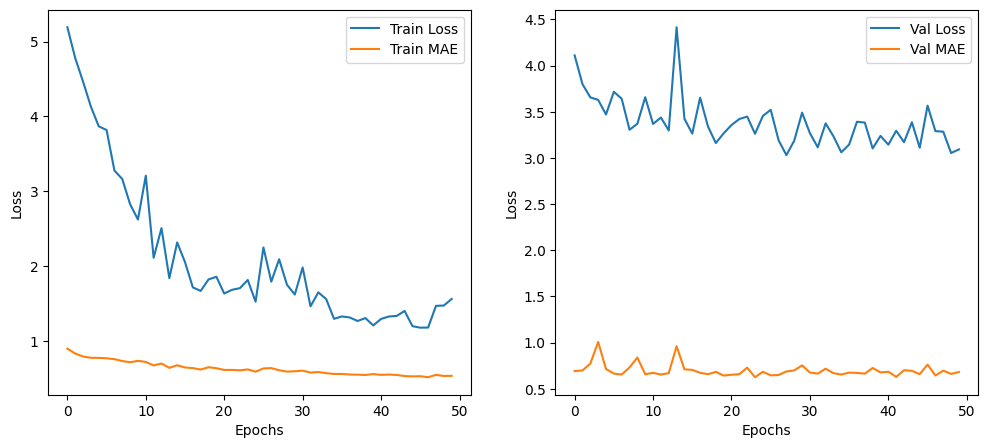

In [38]:
# Plotting loss and mae curves
import matplotlib.pyplot as plt
from tensorflow import keras

history = model.history
# Plotting training loss and training MAE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['mae'], label='Train MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Val Loss')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("../visualizations/nn_loss_mae.png")

In [32]:
# predictions = model.predict(X_test)
from tensorflow import keras

nn_model = keras.models.load_model("../models/nn_model.keras")
predictions = nn_model.predict(X_test)

# Constructing dataframe of names, global sales, and predictions
results_df = pd.DataFrame({
    "Name": X_test_name[:, 0],  # Names from the name-included test set
    "Actual_Global_Sales": y_test,
    "Predicted_Global_Sales": predictions.flatten()
})

# viewing model predictions
results_df

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


c:\Program Files\Python313\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


,Name,Actual_Global_Sales,Predicted_Global_Sales
0,chronicles of mystery the secret tree of life,0.08,0.226882
1,back at the barnyard slop bucket games,0.14,0.290951
2,earth defense force 2025,0.51,1.107718
3,scoobydoo unmasked,0.75,0.513140
4,mlb 10 the show,1.32,0.803662
...,...,...,...
2263,ben 10 omniverse 2,0.03,0.573726
2264,medabots metabee,0.05,0.414014
2265,katekyoo hitman reborn kindan no yami no delta,0.03,0.157533
2266,gaia saver hero saidai no sakusen,0.03,0.272654


In [24]:
# Displaying top 10 highest global sales out of the test set
top_10 = results_df.sort_values(by="Actual_Global_Sales", ascending=False).head(10)
top_10

,Name,Actual_Global_Sales,Predicted_Global_Sales
1852,pokemon redpokemon blue,31.37,8.443211
743,new super mario bros wii,28.62,7.240896
1480,call of duty black ops 3,25.32,21.851910
982,nintendogs,24.76,17.653006
97,wii fit,22.72,10.528362
175,call of duty advanced warfare,21.90,15.319038
1576,fifa 16,16.44,8.714031
575,fifa soccer 13,16.16,15.350302
1395,call of duty world at war,15.87,0.704028
1970,pokemon blackpokemon white,15.32,7.467901


In [25]:
# Displaying top 10 predicted sales out of the test set
top_10_pred = results_df.sort_values(by="Predicted_Global_Sales", ascending=False).head(10)
top_10_pred

,Name,Actual_Global_Sales,Predicted_Global_Sales
1480,call of duty black ops 3,25.32,21.851910
982,nintendogs,24.76,17.653006
575,fifa soccer 13,16.16,15.350302
175,call of duty advanced warfare,21.90,15.319038
1643,the sims 4,2.97,12.301384
1108,grand theft auto 2,3.42,10.873234
97,wii fit,22.72,10.528362
603,fifa soccer 07,6.38,9.545191
1946,wii sports club,0.40,9.358070
1660,assassins creed iii,13.10,9.312297


In [26]:
# Displaying bottom 10 predicted sales out of the test set
bottom_10_pred = results_df.sort_values(by="Predicted_Global_Sales", ascending=True).head(10)
bottom_10_pred

,Name,Actual_Global_Sales,Predicted_Global_Sales
389,super run for money tousouchuu atsumare saikyo...,0.11,0.067634
1484,nil admirari no tenbin teito genwaku toukidan,0.02,0.074597
2129,nobunagas ambition tenshouki with powerup kit ...,0.02,0.076929
1429,toki no kizuna hanayui tsuzuri,0.02,0.087353
1515,moujuutsukai to oujisama snow bride,0.02,0.088861
1533,grisaia no meikyuu le labyrinthe de la grisaia,0.02,0.089928
649,coderealize sousei no himegimi,0.15,0.092134
672,tantei jinguuji saburo hai to diamond,0.01,0.092736
1338,toki no kizuna sekigahara kitan,0.04,0.096463
1039,satomi hakkenden hachi tamanoki,0.01,0.098688


In [27]:
# Displaying bottom 10 global sales out of the test set
bottom_10 = results_df.sort_values(by="Actual_Global_Sales", ascending=True).head(10)
bottom_10

,Name,Actual_Global_Sales,Predicted_Global_Sales
25,sangoku koi senki omoide gaeshi cs edition,0.01,0.116244
1038,thunder alley,0.01,0.805771
1039,satomi hakkenden hachi tamanoki,0.01,0.098688
1725,himawari pebble in the sky portable,0.01,0.228211
1731,monster rancher advance 2,0.01,0.418128
1734,legoland,0.01,1.544206
503,mario luigi paper jam mario kart 7 double pack,0.01,0.430973
1840,tengai makyo dai yon no mokushiroku,0.01,0.150674
425,pachitte chonmage tatsujin 16 pachinko hissats...,0.01,0.221766
1708,il2 sturmovik,0.01,0.338777


In [28]:
# calculating test MAE
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print("Test MAE:", mae)

Test MAE: 0.6392617782833452


In [29]:
# Joining results_df and df_raw on Name to add publisher, genre, franchisetag back to results_df
results_df = results_df.merge(df_raw[['Name', 'Publisher', 'Genre', 'FranchiseTag', 'Year', 'Decade']], on='Name', how='left')
results_df.head()

,Name,Actual_Global_Sales,Predicted_Global_Sales,Publisher,Genre,FranchiseTag,Year,Decade
0,chronicles of mystery the secret tree of life,0.08,0.226882,city interactive,adventure,0,2011,2010
1,back at the barnyard slop bucket games,0.14,0.290951,thq,sports,0,2008,2000
2,earth defense force 2025,0.51,1.107718,d3publisher,shooter,0,2013,2010
3,scoobydoo unmasked,0.75,0.513140,thq,platform,0,2005,2000
4,mlb 10 the show,1.32,0.803662,sony computer entertainment,sports,0,2010,2010


In [106]:
# saving results_df to csv
results_df.to_csv("test_results.csv", index=False)

In [30]:
# Displaying rows with highest prediction errors
results_df['Absolute_Error'] = abs(results_df['Actual_Global_Sales'] - results_df['Predicted_Global_Sales'])
results_df.sort_values(by='Absolute_Error', ascending=False).head(10)

,Name,Actual_Global_Sales,Predicted_Global_Sales,Publisher,Genre,FranchiseTag,Year,Decade,Absolute_Error
1852,pokemon redpokemon blue,31.37,8.443211,nintendo,roleplaying,0,1996,1990,22.926789
743,new super mario bros wii,28.62,7.240896,nintendo,platform,0,2009,2000,21.379104
1395,call of duty world at war,15.87,0.704028,activision,shooter,0,2008,2000,15.165972
97,wii fit,22.72,10.528362,nintendo,sports,0,2007,2000,12.191638
1257,red dead redemption,12.94,0.829383,taketwo interactive,action,0,2010,2010,12.110617
1060,super smash bros for wii u and 3ds,12.47,1.207714,nintendo,fighting,0,2014,2010,11.262286
1674,animal crossing wild world,12.27,1.258206,nintendo,simulation,0,2005,2000,11.011794
1411,the last of us,10.54,0.463511,sony computer entertainment europe,action,0,2013,2010,10.076489
1643,the sims 4,2.97,12.301384,electronic arts,simulation,1,2014,2010,9.331384
1946,wii sports club,0.40,9.358070,nintendo,sports,0,2014,2010,8.958070


In [31]:
# Displaying rows with smallest prediction errors
results_df['Absolute_Error'] = abs(results_df['Actual_Global_Sales'] - results_df['Predicted_Global_Sales'])
results_df.sort_values(by='Absolute_Error', ascending=True).head(10)

,Name,Actual_Global_Sales,Predicted_Global_Sales,Publisher,Genre,FranchiseTag,Year,Decade,Absolute_Error
2212,around the world in 80 days,0.21,0.210160,playv,action,0,2010,2010,0.000160
453,rogue trip vacation 2012,0.38,0.379516,gt interactive,racing,0,1998,1990,0.000484
1415,my spanish coach,0.57,0.569416,ubisoft,misc,0,2007,2000,0.000584
2164,froggers journey the forgotten relic,0.26,0.259322,konami digital entertainment,action,0,2003,2000,0.000678
2087,cartoon network collection game boy advance vi...,0.32,0.318884,unknown,misc,0,2005,2000,0.001116
1353,hitman hd trilogy,0.40,0.398712,square enix,action,0,2013,2010,0.001288
2190,pipe mania,0.30,0.301571,empire interactive,puzzle,0,2008,2000,0.001571
913,golden nugget casino,0.25,0.248381,majesco entertainment,misc,0,2004,2000,0.001619
766,jikkyou powerful pro yakyuu 5,0.27,0.271695,konami digital entertainment,sports,1,1998,1990,0.001695
1140,armored core for answer,0.34,0.338297,ubisoft,simulation,0,2008,2000,0.001703


### Binning Target Variable and Neural Network Predictions For Classification

In [79]:
# Binning global sales into low, medium, high categories
bins = [0, 1, 5, np.inf]
labels = ['Low', 'Medium', 'High']

# Digitize values into bins
y_test_binned = np.digitize(y_test, bins, right=True)
y_pred_binned = np.digitize(results_df["Predicted_Global_Sales"], bins, right=True)

# Map to labels
y_test_categories = [labels[i-1] for i in y_test_binned]
y_pred_categories = [labels[i-1] for i in y_pred_binned]

In [80]:
y_test_binned = y_test_binned - 1    # Convert to 0-based index
y_pred_binned = y_pred_binned - 1    # Convert to 0-based index

In [81]:
from sklearn.metrics import f1_score

f1_score(y_test_binned, y_pred_binned, average='macro')

0.5744729427109355

In [83]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test_binned, y_pred_binned)

0.814373897707231

In [82]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned)
conf_matrix

array([[1720,  138,    7],
       [ 238,  106,    7],
       [   7,   24,   21]])

In [84]:
# Computing classification report
from sklearn.metrics import classification_report

report = classification_report(y_test_binned, y_pred_binned, target_names=labels)
print(report)

              precision    recall  f1-score   support

         Low       0.88      0.92      0.90      1865
      Medium       0.40      0.30      0.34       351
        High       0.60      0.40      0.48        52

    accuracy                           0.81      2268
   macro avg       0.62      0.54      0.57      2268
weighted avg       0.79      0.81      0.80      2268

